# VidProM Prompt Quality Scoring — Modeling
Train and compare regression models to predict prompt quality scores.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

SEED = 42
FEATURES_PATH = "../data/features.parquet"
LABELS_PATH = "../data/labeled_prompts.parquet"
TARGET = "overall"

np.random.seed(SEED)

## Load Data

In [2]:
X = pd.read_parquet(FEATURES_PATH)
labels = pd.read_parquet(LABELS_PATH)
y = labels[TARGET]

print(f"Features: {X.shape}")
print(f"Target distribution:")
print(y.value_counts().sort_index())

Features: (250, 68)
Target distribution:
overall
1     12
2    101
3     85
4     41
5     11
Name: count, dtype: int64


## Train / Test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"Train: {X_train.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")
print(f"\nTrain distribution:\n{y_train.value_counts().sort_index()}")
print(f"\nTest distribution:\n{y_test.value_counts().sort_index()}")

Train: 200 samples
Test: 50 samples

Train distribution:
overall
1     9
2    81
3    68
4    33
5     9
Name: count, dtype: int64

Test distribution:
overall
1     3
2    20
3    17
4     8
5     2
Name: count, dtype: int64


## Baseline - Linear Regression

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_trian_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_trian_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression")
print(f"MAE: {mae:.3f}")
print(f"R²: {r2:.3f}")

Linear Regression
MAE: 0.499
R²: 0.370


## Random Forest

In [5]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=SEED)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest")
print(f"MAE: {mae_rf:.3f}")
print(f"R²: {r2_rf:.3f}")


Random Forest
MAE: 0.299
R²: 0.807


## XGBoost

In [6]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=100, random_state=SEED, verbosity=0)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nXGBoost")
print(f"MAE: {mae_xgb:.3f}")
print(f"R²: {r2_xgb:.3f}")


XGBoost
MAE: 0.304
R²: 0.732


## Feature Importance
What features matter most for prompt quality?

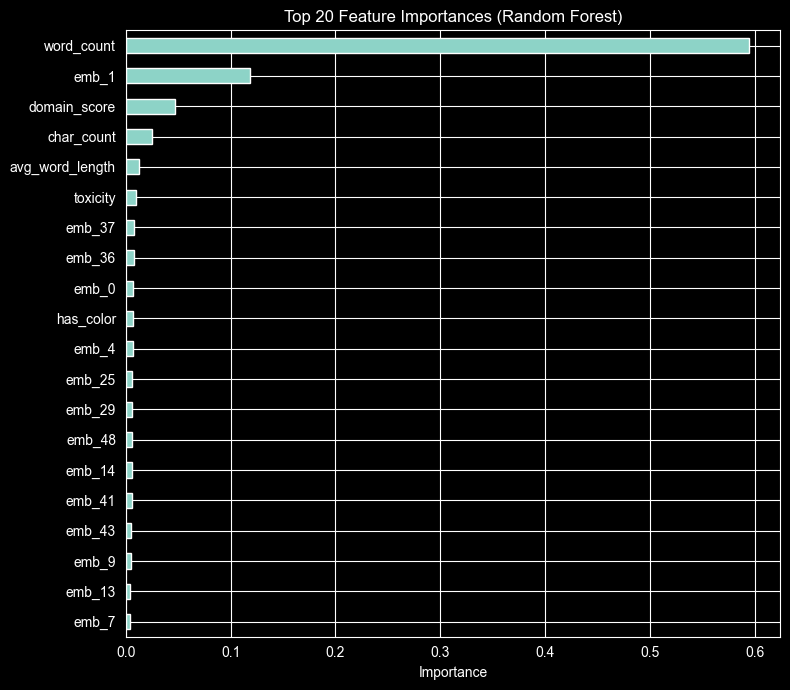


Top 10 features:
word_count         0.5945
emb_1              0.1182
domain_score       0.0469
char_count         0.0253
avg_word_length    0.0128
toxicity           0.0096
emb_37             0.0076
emb_36             0.0076
emb_0              0.0073
has_color          0.0068
dtype: float64


In [7]:
import matplotlib.pyplot as plt

importance = pd.Series(rf.feature_importances_, index=X.columns)
top20 = importance.nlargest(20).sort_values()

plt.figure(figsize=(8, 7))
top20.plot(kind='barh')
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig("../data/feature_importance.png", dpi=100)
plt.show()

print("\nTop 10 features:")
print(importance.nlargest(10).round(4))

## Save Best Model

In [8]:
import pickle

with open("../data/score_model.pkl", "wb") as f:
    pickle.dump({"model": rf, "scaler": scaler, "features": X.columns.tolist()}, f)

print("Saved: score_model.pkl")
print(f"\nFinal model: Random Forest")
print(f"MAE: {mae_rf:.3f}  |   R²: {r2_rf:.3f}")
print(f"\nKey insight for Rewriter:")
print(f" word_count importance: {importance['word_count']:.1%}")
print(f" domain_score importance: {importance['domain_score']:.1%}")

Saved: score_model.pkl

Final model: Random Forest
MAE: 0.299  |   R²: 0.807

Key insight for Rewriter:
 word_count importance: 59.5%
 domain_score importance: 4.7%


## Multi-Output Model
Predict all 4 quality dimensions simultaneously: specificity, clarity, visual richness, overall.

In [9]:
TARGETS = ['specificity', 'clarity', 'visual_richness', 'overall']
X = pd.read_parquet(FEATURES_PATH)
labels = pd.read_parquet(LABELS_PATH)
y = labels[TARGETS]

print(f"X: {X.shape}")
print(f"y: {y.shape}")
print(y.describe().round(2))

X: (250, 68)
y: (250, 4)
       specificity  clarity  visual_richness  overall
count       250.00   250.00           250.00   250.00
mean          3.19     3.73             1.73     2.75
std           1.16     0.91             0.92     0.94
min           1.00     1.00             1.00     1.00
25%           2.00     3.00             1.00     2.00
50%           3.00     4.00             2.00     3.00
75%           4.00     4.00             2.00     3.00
max           5.00     5.00             5.00     5.00


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=labels["overall"]
)

print(f"Train: {X_train.shape[0]}")
print(f"Test: {X_test.shape[0]}")

Train: 200
Test: 50


In [11]:
rf_multi = RandomForestRegressor(n_estimators=100, random_state=SEED)
rf_multi.fit(X_train, y_train)

y_pred_multi = rf_multi.predict(X_test)
print(f"Output shape: {y_pred_multi.shape}")

Output shape: (50, 4)


In [12]:
results = {}
for i, target in enumerate(TARGETS):
    mae = mean_absolute_error(y_test[target], y_pred_multi[:, i])
    r2 = r2_score(y_test[target], y_pred_multi[:, i])
    results[target] = {"MAE": round(mae, 3), "R²": round(r2, 3)}

results_df = pd.DataFrame(results).T
print(results_df)

                   MAE     R²
specificity      0.232  0.873
clarity          0.228  0.858
visual_richness  0.351  0.697
overall          0.288  0.804


### Single vs Multi-Output Comparison
  | Model | Target | MAE | R² |
  |---|---|---|---|
  | RF single | overall | 0.299 | 0.807 |
  | RF multi | overall | 0.288 | 0.804 |
Multi-output predicts all 4 dimensions with minimal trade-off on overall quality.

In [14]:
with open("../data/score_model.pkl", "wb") as f:
    pickle.dump({
        "model": rf_multi,
        "scaler": scaler,
        "features": X.columns.tolist(),
        "targets": TARGETS
    }, f)

print("Saved: score_model.pkl")
print(f"Targets: {TARGETS}")

Saved: score_model.pkl
Targets: ['specificity', 'clarity', 'visual_richness', 'overall']
